In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from time_series_preprocessing import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
AAPL = pd.read_csv("../../Stock-Price-Prediction/data/dataset/APPL.csv")
AAPL["Date"] = pd.to_datetime(AAPL["Date"])
AAPL.set_index("Date", inplace=True)

In [3]:
AAPL

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.845036,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.075386,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.530045,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.450966,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.126766,164101200
...,...,...,...,...,...,...
2024-04-08,169.029999,169.199997,168.240005,168.449997,168.449997,37425500
2024-04-09,168.699997,170.080002,168.350006,169.669998,169.669998,42451200
2024-04-10,168.800003,169.089996,167.110001,167.779999,167.779999,49709300


In [4]:
def plot_results(df, y_test, y_test_pred, model_name):
    fig = plt.figure(figsize=(7.2, 4.8), dpi=65)
    plt.plot(df.index[-len(y_test):], y_test, label='Actual Price')
    plt.plot(df.index[-len(y_test):], y_test_pred, label='Predicted Price')
    plt.title(f'Stock Price Prediction using {model_name} Regression')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend(loc=4)
    plt.show()

Random Forest

In [5]:
def random_forest_algo(df):
    # Number of days to be forecasted in the future
    forecast_out = 7
    
    # Price after n days
    df['Close after n days'] = df['Close'].shift(-forecast_out)
    
    # New DataFrame with only relevant data
    df_new = df[['Close', 'Close after n days']]

    # Structure data for training, testing, and forecasting
    # Labels of known data, discard last 7 rows
    y = np.array(df_new.iloc[:-forecast_out, -1])
    y = np.reshape(y, (-1, 1))
    
    # All columns of known data except labels, discard last 7 rows
    X = np.array(df_new.iloc[:-forecast_out, 0:-1])
    
    # Unknown, X to be forecasted
    X_to_be_forecasted = np.array(df_new.iloc[-forecast_out:, 0:-1])

    # Training, testing to plot graphs and check accuracy
    X_train = X[0:int(0.8 * len(df)), :]
    X_test = X[int(0.8 * len(df)) - forecast_out:-forecast_out, :]
    y_train = y[0:int(0.8 * len(df)), :]
    y_test = y[int(0.8 * len(df)) - forecast_out:-forecast_out, :]

    # Feature Scaling (Normalization)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    X_to_be_forecasted = sc.transform(X_to_be_forecasted)

    # Training
    clf = RandomForestRegressor(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train.ravel())

    # Testing
    y_test_pred = clf.predict(X_test)
    y_test_pred = y_test_pred * (1.04)  # Adjust for prediction error

    # Plotting
    plot_results(df, y_test, y_test_pred, 'Random Forest')

    # Calculate RMSE
    error_rf = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Forecasting
    forecast_set = clf.predict(X_to_be_forecasted)
    forecast_set = forecast_set * (1.04)  # Adjust for prediction error
    mean = forecast_set.mean()
    rf_pred = forecast_set[0]

    print()
    print("------")
    print("Random Forest RMSE:", error_rf)
    print("------")

    return df, rf_pred, forecast_set, mean, error_rf

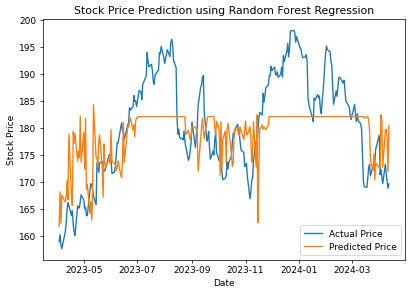


------
Random Forest RMSE: 7.708669052432261
------


(                  Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2019-01-02   38.722500   39.712502   38.557499   39.480000   37.845036   
 2019-01-03   35.994999   36.430000   35.500000   35.547501   34.075386   
 2019-01-04   36.132500   37.137501   35.950001   37.064999   35.530045   
 2019-01-07   37.174999   37.207500   36.474998   36.982498   35.450966   
 2019-01-08   37.389999   37.955002   37.130001   37.687500   36.126766   
 ...                ...         ...         ...         ...         ...   
 2024-04-08  169.029999  169.199997  168.240005  168.449997  168.449997   
 2024-04-09  168.699997  170.080002  168.350006  169.669998  169.669998   
 2024-04-10  168.800003  169.089996  167.110001  167.779999  167.779999   
 2024-04-11  168.339996  175.460007  168.160004  175.039993  175.039993   
 2024-04-12  174.259995  178.360001  174.210007  176.550003  176.550003   
 
                Volume 

In [6]:
random_forest_algo(AAPL)

XGBoost

In [7]:
def xgboost_algo(df):
    # Number of days to be forecasted in the future
    forecast_out = 7
    
    # Price after n days
    df['Close after n days'] = df['Close'].shift(-forecast_out)
    
    # New DataFrame with only relevant data
    df_new = df[['Close', 'Close after n days']]

    # Structure data for training, testing, and forecasting
    # Labels of known data, discard last 7 rows
    y = np.array(df_new.iloc[:-forecast_out, -1])
    y = np.reshape(y, (-1, 1))
    
    # All columns of known data except labels, discard last 7 rows
    X = np.array(df_new.iloc[:-forecast_out, 0:-1])
    
    # Unknown, X to be forecasted
    X_to_be_forecasted = np.array(df_new.iloc[-forecast_out:, 0:-1])

    # Training, testing to plot graphs and check accuracy
    X_train = X[0:int(0.8 * len(df)), :]
    X_test = X[int(0.8 * len(df)) - forecast_out:-forecast_out, :]
    y_train = y[0:int(0.8 * len(df)), :]
    y_test = y[int(0.8 * len(df)) - forecast_out:-forecast_out, :]

    # Feature Scaling (Normalization)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    X_to_be_forecasted = sc.transform(X_to_be_forecasted)

    # Training
    clf = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, random_state=42)
    clf.fit(X_train, y_train.ravel())

    # Testing
    y_test_pred = clf.predict(X_test)
    y_test_pred = y_test_pred * (1.04)  # Adjust for prediction error

    # Plotting
    plot_results(df, y_test, y_test_pred, 'XGBoost')

    # Calculate RMSE
    error_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Forecasting
    forecast_set = clf.predict(X_to_be_forecasted)
    forecast_set = forecast_set * (1.04)  # Adjust for prediction error
    mean = forecast_set.mean()
    xgb_pred = forecast_set[0]

    print()
    print("------")
    print("XGBoost RMSE:", error_xgb)
    print("------")

    return df, xgb_pred, forecast_set, mean, error_xgb

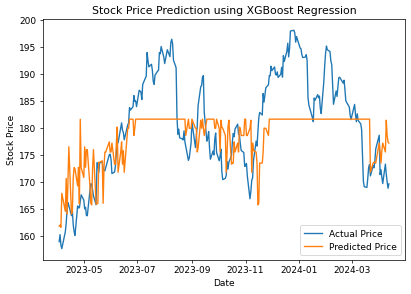


------
XGBoost RMSE: 7.609468966009521
------


(                  Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2019-01-02   38.722500   39.712502   38.557499   39.480000   37.845036   
 2019-01-03   35.994999   36.430000   35.500000   35.547501   34.075386   
 2019-01-04   36.132500   37.137501   35.950001   37.064999   35.530045   
 2019-01-07   37.174999   37.207500   36.474998   36.982498   35.450966   
 2019-01-08   37.389999   37.955002   37.130001   37.687500   36.126766   
 ...                ...         ...         ...         ...         ...   
 2024-04-08  169.029999  169.199997  168.240005  168.449997  168.449997   
 2024-04-09  168.699997  170.080002  168.350006  169.669998  169.669998   
 2024-04-10  168.800003  169.089996  167.110001  167.779999  167.779999   
 2024-04-11  168.339996  175.460007  168.160004  175.039993  175.039993   
 2024-04-12  174.259995  178.360001  174.210007  176.550003  176.550003   
 
                Volume 

In [8]:
xgboost_algo(AAPL)